In [1]:
#base python packages
import os
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd

#geospatial packages
import geopandas as gpd
import rasterio as rio
import rasterio.plot
from shapely.geometry import Point
from rasterio.mask import mask
from shapely.ops import linemerge

#functions to make transects
from transect_extraction_functions import addpts, make_perp_transects

## Load stitched and clipped DTM of study section

In [6]:
proj_fn = r'../../data/ex_Waal_section_data/rkm878to888_clipped_DTM.tif'

In [7]:
src_proj = rio.open(proj_fn)

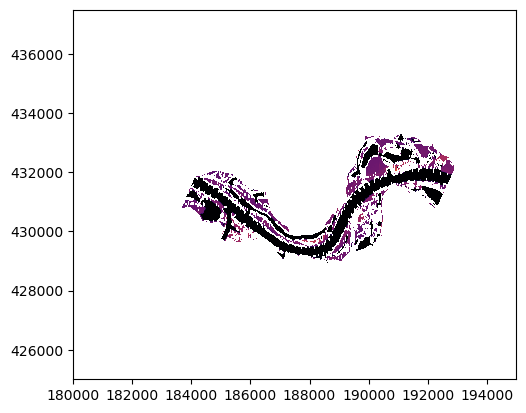

<Axes: >

In [8]:
rio.plot.show(src_proj,
              cmap='inferno')

In [9]:
nodataval = src_proj.nodata

## Load centerline shapefile

<Axes: >

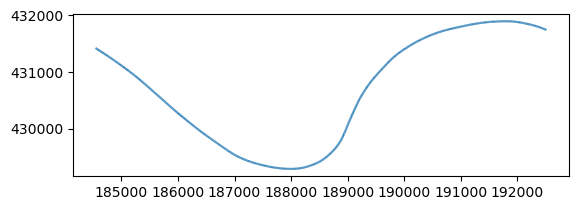

In [10]:
clipped_centerline_fn = r'../../data/ex_Waal_section_data/Waal_centerline_rkm878to888.shp'
clipped_centerline_gdf = gpd.read_file(clipped_centerline_fn)
clipped_centerline_gdf.geometry.plot()

Merge centerline into a single geometry for subsequent processing

In [11]:
river_centerline = linemerge(clipped_centerline_gdf.geometry.iloc[0])

## Create transects

##### First Create equidistant points along centerline

In [12]:
along_l_dist, xpts, ypts = addpts(river_centerline, 100)

##### next create transects
here the length of each transect is 3.5km and we preparing to sample the DEM at 3m spacing across the transect

In [13]:
chan_transects = make_perp_transects(xpts, ypts, 3500, DEM_res=3)

In [14]:
ntrans = len(chan_transects)

##### sample topography from DTM across transects

In [15]:
#sample DTM at transect points
z_samples = []
for i in range(len(chan_transects)):
    #sample z values using rasterio nearest neighbor
    trans_points = [(x,y) for (x,y) in zip(chan_transects[i][0], chan_transects[i][1])]
    sampled = np.fromiter(rio.sample.sample_gen(src_proj, trans_points),
                          dtype='float') 
    z_samples.append(sampled)

### create nice storage for our transects

In [16]:
transects_gdfs = {}
for i in range(ntrans):
    transects_gdfs['t%d'%i] = gpd.GeoDataFrame(crs = 'EPSG:32610',
                                               geometry = [Point(x, y) for x, y in zip(chan_transects[i][0], chan_transects[i][1])])
    transects_gdfs['t%d'%i]['dist_along_line'] = chan_transects[i][2]
    transects_gdfs['t%d'%i]['x_coord'] = chan_transects[i][0]
    transects_gdfs['t%d'%i]['y_coord'] = chan_transects[i][1]
    transects_gdfs['t%d'%i]['elev'] = z_samples[i]

## Plots

#### Plot transects

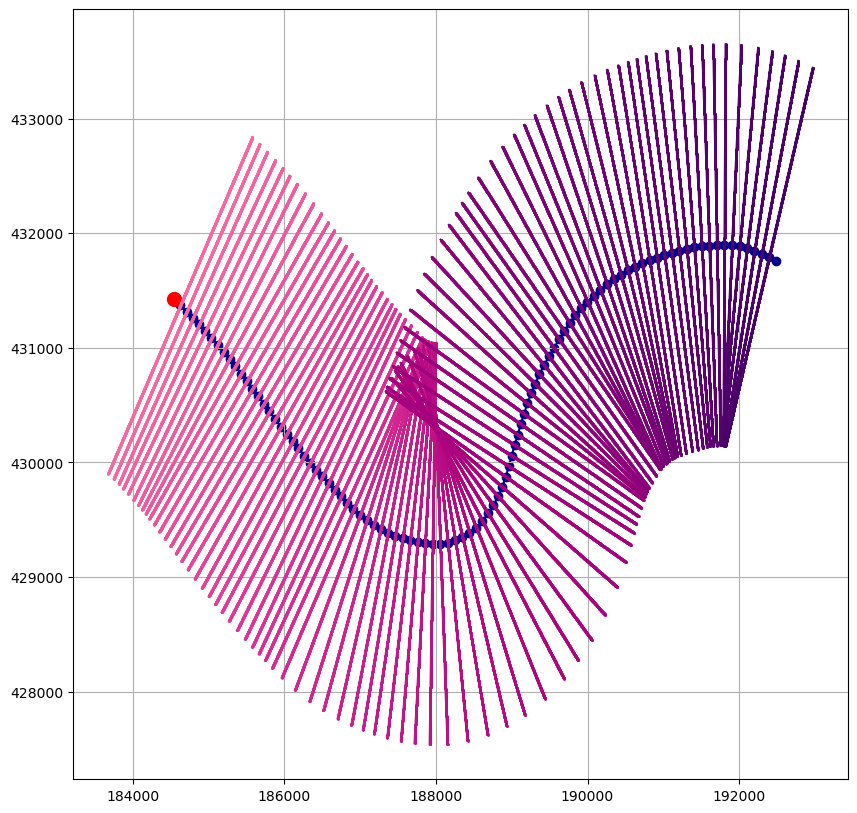

In [17]:
f, ax = mp.subplots(figsize=(10,10)) #can resize so it's not skewed
cm_index = np.linspace(0.5, 1, ntrans) #dummy index for transect coloring
ax.plot(xpts,
        ypts,
        color='darkblue',
        marker='o', zorder=0)
ax.scatter(xpts[0],
           ypts[0],
           color='red', s=100, zorder=1)
for i, c_idx in zip(range(ntrans), cm_index):
    ax.plot(chan_transects[i][0],
            chan_transects[i][1],
            color=mp.cm.RdPu(c_idx),
            marker='o',
            markersize=1) 

ax.grid(True)

#### Plot topography

Text(0.5, 0, 'dist across transect (m)')

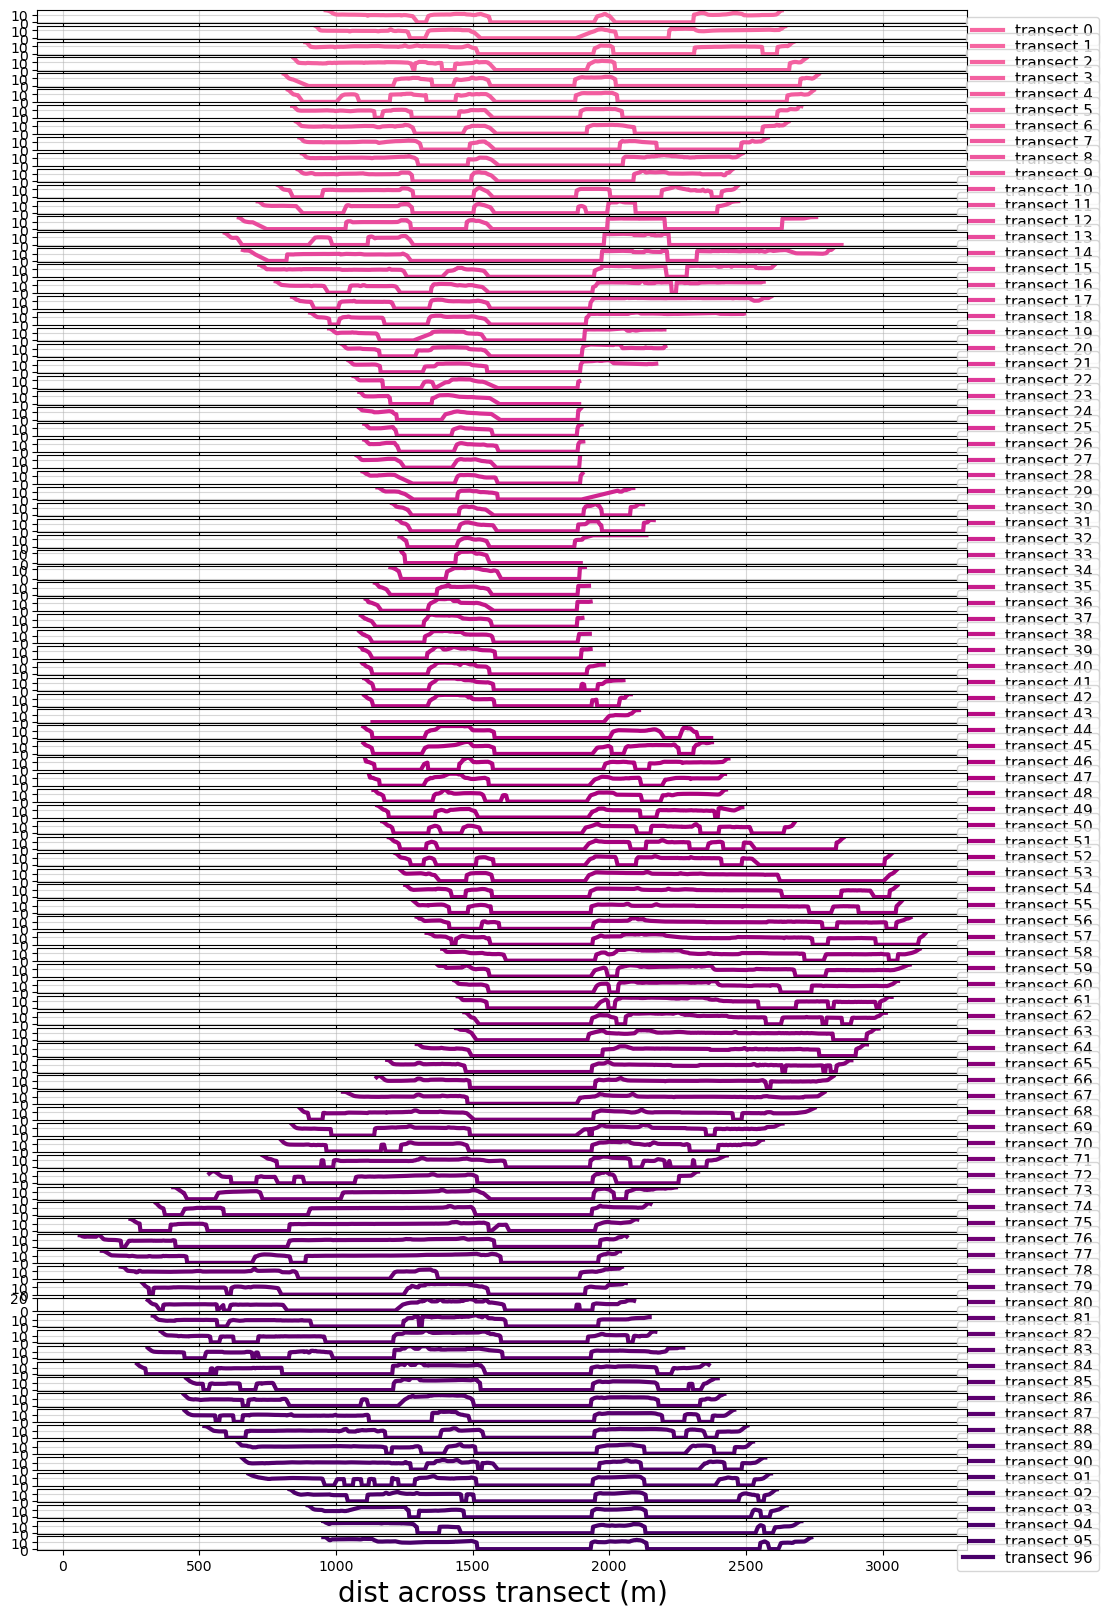

In [18]:
f, axs = mp.subplots(nrows=ntrans, ncols=1, figsize=(12,20), sharex=True)
cm_index = np.linspace(0.5, 1, ntrans) #iterate through colorspace
for i, c_idx in zip(range(ntrans), cm_index):
    
    no_data_filter = transects_gdfs['t%d'%i]['elev'] < nodataval #do this to not plot no data value
    
    axs[i].plot(transects_gdfs['t%d'%i]['dist_along_line'][no_data_filter],
                transects_gdfs['t%d'%i]['elev'][no_data_filter],
                color=mp.cm.RdPu(c_idx),
                label='transect %d'%i,
                linewidth=3)
    axs[i].grid(True, alpha=0.5)
    axs[i].legend(loc='upper right', bbox_to_anchor=(1.15,1.0), fontsize=11)
axs[-1].set_xlabel('dist across transect (m)', fontsize=20)